# Processing Real estate transactions dataset 

In [1]:
import sys
!{sys.executable} -m pip install geodatasets
!{sys.executable} -m pip install folium>=0.12
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install mapclassify
!{sys.executable} -m pip install h3

In [1]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geodatasets
import h3
from shapely.geometry import Polygon

## Downloading directly 

In [2]:
relev_cols=['anneemut','datemut','valeurfonc','coddep','sbati','sterr','geompar_x','geompar_y','libtypbien']

In [4]:
# Online version 
url = 'https://minio.lab.sspcloud.fr/tomvxz/diffusion/transac.parquet'
df_reduced = pd.read_parquet(url, columns=relev_cols)

In [3]:
# Offline version if available
df_reduced = pd.read_parquet('transac.parquet',columns=relev_cols)

## Dictionary of variables - Dataset DV3F (Cerema)


Explaination from the variables come from here, they were formatted by ChatGPT : https://doc-datafoncier.cerema.fr/doc/dv3f/mutation. Most of them are useless in this case

This dataset comes from the **French Property Transaction Database (DVF – Demandes de Valeurs Foncières)** processed by **Cerema**. It records **real estate transactions carried out for consideration** (sales, exchanges, auctions).

### 1. Identifiers and References
These keys ensure row uniqueness or allow joins with other datasets (Land Registry / MAJIC files).

| Column | Description |
| :--- | :--- |
| **`idmutation`** | Unique transaction identifier (generated by Cerema). |
| `idmutinvar` | Stable identifier used to join with Land Registry (MAJIC) files. |
| `idopendata` | Original identifier from the raw DVF file (DGFiP). |
| `codservch` | Code of the Land Registration Office (SPF). |
| `refdoc` | Publication reference (Volume / Number). |

### 2. Transaction Date and Nature

| Column | Description |
| :--- | :--- |
| **`datemut`** | Exact date of the transaction. |
| `anneemut` | Year of the transaction. |
| `moismut` | Month of the transaction. |
| `idnatmut` | Code describing the nature of the transaction (1 = Sale, etc.). |
| **`libnatmut`** | Label describing the nature (e.g. *Sale*, *Sale of a property under construction*). |
| **`vefa`** | Boolean indicator: Sale of a Property Under Construction (new housing). |
| `nbartcgi` | Number of tax code articles applied. |
| `l_artcgi` | List of applicable tax code articles. |
| `nbdispo` | Number of legal provisions included in the deed. |

### 3. Geographic Location

| Column | Description |
| :--- | :--- |
| `coddep` | Department code (e.g. 75, 59). |
| `nbcomm` | Number of municipalities involved. |
| `l_codinsee` | List of INSEE municipality codes. |
| `nbsection` / `l_section` | Number and list of cadastral sections. |
| `nbpar` / `l_idpar` | Number and list of parcel identifiers involved. |
| `nbparmut` / `l_idparmut` | Number and list of parcels **actually transferred**. |
| `geompar_x` / `geompar_y` | Geographic coordinates (centroids). |

### 4. Price and Land (Plot Characteristics)

| Column | Description |
| :--- | :--- |
| **`valeurfonc`** | **Total transaction value** (net of seller). *Sum for all properties included in the transaction.* |
| `sterr` | Total land area (m²). |
| `l_dcnt` | List of cadastral land areas. |
| `nbsuf` | Number of land surfaces (link with Land Registry files). |

### 5. Building Characteristics (General)

| Column | Description |
| :--- | :--- |
| `codtypbien` | Property typology code (computed by Cerema). |
| **`libtypbien`** | Typology label (e.g. *House*, *Existing apartment*, *Building land*). |
| **`sbati`** | Total built surface area (m²) for all premises. |
| `nblot` | Number of condominium lots. |
| `nbvolmut` | Number of volumes transferred. |
| `nblocmut` | Total number of premises transferred. |
| `l_idlocmut` | List of premises identifiers. |

### 6. Breakdown by Type of Premises
Distribution of premises by category and associated surface areas.

| Column (Count) | Column (Surface) | Description |
| :--- | :--- | :--- |
| `nblocmai` | `sbatmai` | Number and built area of **Houses**. |
| `nblocapt` | `sbatapt` | Number and built area of **Apartments**. |
| `nblocact` | `sbatact` | Number and built area of **Commercial / Activity premises**. |
| `nblocdep` | – | Number of isolated **Outbuildings**. |

### 7. Breakdown by Number of Rooms (Housing Units)
Detail by number of main rooms.  
*Note: `5pp` corresponds to “5 rooms or more”.*

| Type | Counts | Surface Areas (m²) |
| :--- | :--- | :--- |
| **Apartments** | `nbapt1pp` to `nbapt5pp` | `sapt1pp` to `sapt5pp` |
| **Houses** | `nbmai1pp` to `nbmai5pp` | `smai1pp` to `smai5pp` |

---

> **Important note for analysis:**  
> The **`valeurfonc`** variable represents the **total value of the transaction** (`idmutation`).  
> If a single row includes multiple properties (e.g. a building with `nblocapt = 10` apartments), the recorded value corresponds to the **total price of the building**, not the price per apartment.


## Cleaning 

In [5]:
#Checking for na values and non-relevant ones (0 and 1€ transactions)
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==1].count()) 
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==0].count())
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc'].isna()].count())

102501
5288
0


In [29]:
# Following previous anaylysis, we clean the data 

# Removing irrelevant transactions based on price
view_price = df_reduced.loc[:,'valeurfonc']
view_geo = df_reduced.loc[:,'geompar_x']
view_s = df_reduced.loc[:,'sbati']
filter = (view_price==0) | (view_price==1)  | (view_price.isna()) | (view_geo.isna()) | (view_s == 0)
df_cleaned = df_reduced[~filter].copy()


In [7]:
# We check the other columns 
for col in relev_cols:
    print(df_cleaned[col].isna().sum())

0
0
0
0
0
0
0
0
0


In [8]:
# We check for weird case that could happen else than na values
print(df_cleaned['anneemut'].min(),df_cleaned['anneemut'].max()) #Checking the range of years
print(df_cleaned['datemut'].min(),df_cleaned['datemut'].max()) #Checking concistency with years
print(df_cleaned['valeurfonc'].min(),df_cleaned['valeurfonc'].max()) #Checking range of prices
print(df_cleaned['sbati'].min(),df_cleaned['sbati'].max()) #Checkin range of surfaces
print(df_cleaned['sterr'].min(),df_cleaned['sterr'].max())

2014 2025
2014-01-01 2025-06-30
0.01 14149999600.0
0.0 706238.0
0.0 35055638.0


In [9]:
df_cleaned['coddep'].unique() # Checking coherent dep codes


array(['79', '51', '45', '92', '86', '87', '93', '44', '50', '78', '46',
       '52', '85', '91', '90', '84', '53', '47', '43', '80', '94', '95',
       '81', '56', '42', '54', '40', '83', '82', '69', '41', '55', '32',
       '26', '27', '33', '2A', '19', '25', '31', '30', '24', '18', '2B',
       '34', '8', '9', '35', '21', '37', '23', '22', '36', '13', '7', '6',
       '12', '38', '4', '10', '11', '5', '39', '1', '15', '29', '28',
       '14', '16', '2', '3', '17', '58', '70', '64', '972', '973', '65',
       '71', '59', '73', '971', '72', '66', '62', '76', '89', '974', '88',
       '77', '63', '75', '61', '49', '48', '60', '74'], dtype=object)

In [10]:
df_reduced["coddep"].nunique()
#for a weird reason there seems to be only 97 departments in this dataset, without further time to inquire about the reasons of this, we will just ignore this problem

97

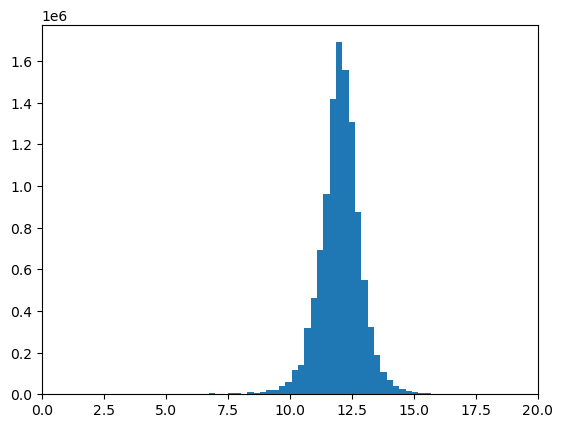

In [30]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['valeurfonc']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.xlim([0,20])
plt.show()

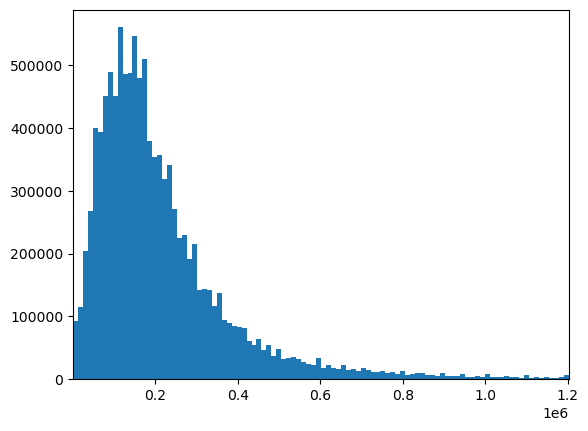

In [31]:
# Creating bins with numpy for faster computations
df_histo = df_cleaned.loc[np.log(df_cleaned['valeurfonc'])<=14]['valeurfonc']
counts, bin_edges = np.histogram(df_histo, bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.margins(x=0)
plt.show()

In [33]:
# Removing extreme price values
df_cleaned = df_cleaned[ (np.log(df_cleaned['valeurfonc'])>=15) | (np.log(df_cleaned['valeurfonc']<=7.5)) ].copy()

/Users/tombourdareau/miniconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


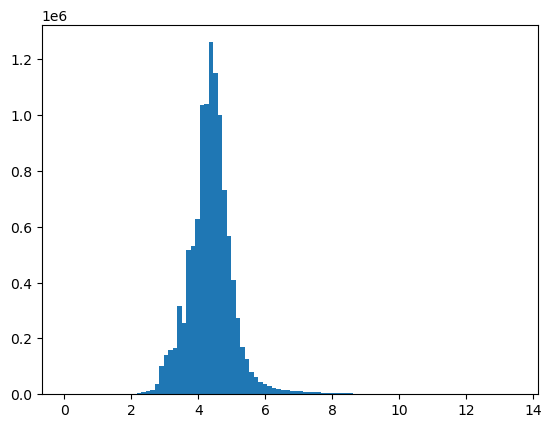

In [36]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['sbati']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.show()

In [37]:
# Since valeurfonc is highly dependant on the size of the building/house sold, we look at price/m2
# We choose to divide first by the built surface (other approches to come)
df_cleaned.loc[:,'p/m2']=df_cleaned['valeurfonc']/df_cleaned['sbati']

In [10]:
# Voir comment utiliser
df_cleaned['libtypbien'].unique()

array(['UNE MAISON', 'TERRAIN DE TYPE TERRE ET PRE',
       'TERRAIN DE TYPE TAB', 'UN APPARTEMENT',
       'TERRAIN NON BATIS INDETERMINE', 'TERRAIN LANDES ET EAUX',
       'TERRAIN FORESTIER', 'DES MAISONS', 'TERRAIN ARTIFICIALISE MIXTE',
       'BATI - INDETERMINE : Vefa sans descriptif', 'ACTIVITE',
       'TERRAIN VITICOLE', 'DES DEPENDANCES', 'BATI MIXTE - LOGEMENTS',
       'BATI - INDETERMINE : Vente avec volume(s)',
       'BATI MIXTE - LOGEMENT/ACTIVITE', "TERRAIN D'AGREMENT",
       'UNE DEPENDANCE', 'APPARTEMENT INDETERMINE',
       'TERRAIN AGRICOLE MIXTE', 'DEUX APPARTEMENTS', 'TERRAIN VERGER',
       "TERRAIN D'EXTRACTION", 'TERRAIN DE TYPE RESEAU',
       'TERRAIN NATUREL MIXTE', 'MAISON - INDETERMINEE'], dtype=object)

## Vizualization

In [45]:
# Geopandas

projections = {
    "Metro":  "EPSG:2154",  # Lambert 93 (France entière hors DOM)
    "971":    "EPSG:5490",  # Guadeloupe (UTM 20N)
    "972":    "EPSG:5490",  # Martinique (UTM 20N)
    "973":    "EPSG:2972",  # Guyane (UTM 22N)
    "974":    "EPSG:2975",  # La Réunion (UTM 40S)
    "976":    "EPSG:4471",   # Mayotte
}

parts = []

#Handling each zones (DOM/TOM have specific zones)
for zone, epsg_code in projections.items():
    if zone == "Metro":
        # Everything that is not a DOM/TOM
        subset = df_cleaned.loc[~((df_cleaned['coddep'].str.startswith('97')) | (df_cleaned['coddep'].isin(['13', '26'])))]
    else:
        # Take specific zone
        subset = df_cleaned.loc[df_cleaned['coddep'] == zone]
    
    if not subset.empty:
        gdf_subset = gpd.GeoDataFrame(
            subset,
            geometry=gpd.points_from_xy(subset['geompar_x'], subset['geompar_y']),
            crs=epsg_code
        )
        
        # Converting to GPS coordinates
        gdf_subset = gdf_subset.to_crs("EPSG:4326")
        
        parts.append(gdf_subset)

gdf_final = pd.concat(parts)



In [ ]:
# We check that our geometries are non-empty
print(gdf_final.geometry.is_empty.sum()) 

0


In [12]:
gdf_final.sample(100).explore()

## Per department

In [13]:
gdf_final["coddep"] = gdf_final["coddep"].str.zfill(2)

In [46]:
gdf_final["coddep"].nunique()

95

Out of the 97 departments that were imported at the beginning (105 minus 5 DOM, 3 "Alsace-Lorraine" dep.), 2 of them have disappeared due to cleaning

### Number of real_estate transactions per person

In [47]:
# First, we groupby for each department by numbers of transactions
nb_transac_per_dep = gdf_final.groupby("coddep").size().reset_index(name='Number_transactions')
nb_transac_per_dep.to_csv("nb_transac_per_dep.csv")

In [48]:
def deps_pop_init():
    deps_pop = pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/2012713/TCRD_004.xlsx")
    deps_pop.columns = deps_pop.iloc[2]
    deps_pop = deps_pop.iloc[3:]
    deps_pop = deps_pop.reset_index()
    deps_pop.columns = ["to_del", "code", "deps_name", "2025", "share_pop","2022", "2016","2011","1999"]
    deps_pop.set_index("code")
    deps_pop = deps_pop.loc[0:101,["code","2011","2025"]]
    return deps_pop

deps_pop = deps_pop_init()

In [49]:
def add_department_pop(df):
    df = df.reset_index()
    df = df.merge(
        deps_pop[["code", "2011", "2025"]],
        left_on="coddep",
        right_on="code",
        how="left"
    )
    df = df.drop(columns=["code"]).set_index("coddep")
    return df

In [50]:
deps = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson")

def add_department_name(df):
    df = df.merge(
        deps[["code", "nom"]],
        left_on="coddep",
        right_on="code",
        how="left"
    )

    df["coddep"] = (
        df["code"].astype(str) + " - " + df["nom"]
    )

    df = (
        df
        .drop(columns=["code", "nom"])
        .set_index("coddep")
    )

    return df

In [51]:
nb_transac_per_dep = nb_transac_per_dep[["coddep","Number_transactions"]]
nb_transac_per_dep.rename(columns={"coddep": "Code du département du lieu des travaux - Code de la zone"})
nb_transac_per_pop_dep = add_department_pop(nb_transac_per_dep)
nb_transac_per_pop_dep["transac_freq"] =  nb_transac_per_pop_dep["Number_transactions"]/nb_transac_per_pop_dep["2025"]


In [52]:
add_department_name(nb_transac_per_pop_dep["transac_freq"].sort_values(ascending=False).to_frame().head(10))


,transac_freq
coddep,
66 - Pyrénées-Orientales,0.251015
73 - Savoie,0.245953
83 - Var,0.238013
11 - Aude,0.23481
17 - Charente-Maritime,0.228665
34 - Hérault,0.217403
74 - Haute-Savoie,0.217164
14 - Calvados,0.207541
85 - Vendée,0.205045


Number of real estate transactions per population could be an indicator of how intensive is the trading in a place, which could be an indicator of speculation, defined as buying a property to make monetary profit from the variation of price. 
However, population does not take into account secondary residency owned by non resident of a department. 


### Growth of p/m2

In [53]:
median_pm2_per_dep = gdf_final.groupby("coddep")["p/m2"].median().to_frame()
add_department_name(median_pm2_per_dep["p/m2"].sort_values(ascending=False).to_frame().head(10))

,p/m2
coddep,
75 - Paris,9307.692308
92 - Hauts-de-Seine,6247.916667
94 - Val-de-Marne,4488.000000
NaN,4071.428571
74 - Haute-Savoie,3757.575758
78 - Yvelines,3688.032787
93 - Seine-Saint-Denis,3666.666667
83 - Var,3350.427350
2A - Corse-du-Sud,3333.333333


In [54]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep

anneemut,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
coddep,,,,,,,,,,,,
1,1912.769886,1867.037202,1864.782609,1923.076923,1980.952381,2016.189516,2111.325000,2275.862069,2500.970588,2468.724849,2382.978723,2431.282605
10,1250.000000,1238.095238,1244.451220,1250.000000,1240.206186,1260.869565,1316.417910,1414.459930,1522.557666,1524.264087,1428.571429,1457.738095
11,1533.333333,1509.060009,1538.894231,1542.857143,1532.940789,1540.000000,1558.139535,1689.039039,1782.582757,1774.193548,1796.666667,1823.055028
12,1173.815496,1188.970588,1164.179104,1211.511387,1226.410256,1220.535714,1260.416667,1313.131313,1401.515152,1428.571429,1402.784204,1491.803279
14,1963.909693,1904.639175,1950.000000,1973.684211,1980.769231,2052.631579,2187.500000,2393.838384,2602.739726,2593.142857,2583.892617,2611.111111
...,...,...,...,...,...,...,...,...,...,...,...,...
95,3000.000000,2955.555556,2921.568627,3000.000000,3077.922078,3181.818182,3306.559140,3494.117647,3653.846154,3523.076923,3304.347826,3275.862069
971,1983.513805,2016.666667,2119.429590,2174.510890,2152.542373,2321.428571,2479.018773,2530.738221,2730.747507,2898.734177,2855.307692,2473.118280
972,1969.100000,2090.909091,2121.212121,2183.908046,2167.670683,2226.778711,2380.000000,2386.934673,2523.750000,2428.571429,2500.000000,2685.984848


In [55]:
pm2_growth_per_dep = pm2_growth_per_dep.pct_change(axis=1)
pm2_growth_per_dep = pm2_growth_per_dep.quantile(0.9,axis=1).to_frame()
pm2_growth_per_dep

,0.9
coddep,
1,0.077931
10,0.074476
11,0.055383
12,0.063459
14,0.087266
...,...
95,0.045714
971,0.078459
972,0.068808


In [56]:
add_department_name(pm2_growth_per_dep[0.9].sort_values(ascending=False).to_frame()).head(10)

,0.9
coddep,
29 - Finistère,0.128287
56 - Morbihan,0.115112
49 - Maine-et-Loire,0.108789
35 - Ille-et-Vilaine,0.104196
85 - Vendée,0.100463
22 - Côtes-d'Armor,0.093263
40 - Landes,0.092919
44 - Loire-Atlantique,0.092382
73 - Savoie,0.087798


In [57]:
pm2_growth_pop_per_dep = add_department_pop(pm2_growth_per_dep)
pm2_growth_pop_per_dep["pop_growth"] = (pm2_growth_pop_per_dep["2025"]-pm2_growth_pop_per_dep["2011"])/pm2_growth_pop_per_dep["2025"]

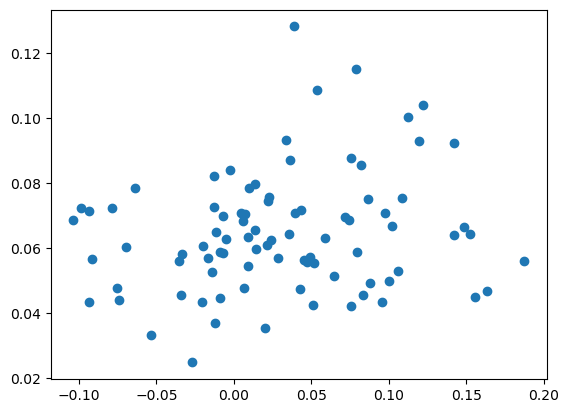

In [58]:
plt.scatter(
    pm2_growth_pop_per_dep["pop_growth"],
    pm2_growth_pop_per_dep[0.9]
)

Departments where there was high increases of prices during the period are not departments that had high level of population growth

What if we look at the "average" (we will here take median as the dataset contains extremely low and extremely high values) growth rate of prices during the period ? 


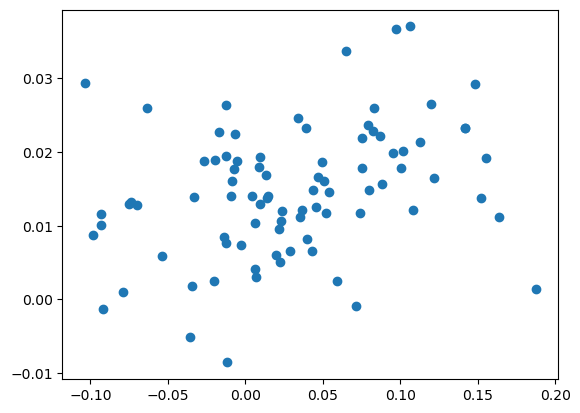

In [59]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep = pm2_growth_per_dep.pct_change(axis=1)
pm2_growth_per_dep = pm2_growth_per_dep.quantile(0.5,axis=1).to_frame()
add_department_name(pm2_growth_per_dep[0.5].sort_values(ascending=False).to_frame()).head(10)
pm2_growth_pop_per_dep = add_department_pop(pm2_growth_per_dep)
pm2_growth_pop_per_dep["pop_growth"] = (pm2_growth_pop_per_dep["2025"]-pm2_growth_pop_per_dep["2011"])/pm2_growth_pop_per_dep["2025"]
plt.scatter(
    pm2_growth_pop_per_dep["pop_growth"],
    pm2_growth_pop_per_dep[0.5]
)

In [60]:
add_department_name(pm2_growth_pop_per_dep.loc[pm2_growth_pop_per_dep[0.5]>0.06])


,0.5,2011,2025,pop_growth
coddep,,,,


These are the departments where median price growth over the period was the highest, despite normal or even negative population growth. These departments do not seem to have any distinctive feature

In [61]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep.iloc[18:45,]


anneemut,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
coddep,,,,,,,,,,,,
29,1337.143977,1333.333333,1333.333333,1364.341085,1392.156863,1439.393939,1567.235936,1768.292683,2017.058824,2086.206897,2068.181818,2062.500000
2A,2962.962963,2969.882246,2991.326496,3120.000000,3135.345997,3205.570493,3250.000000,3606.238625,3768.224638,3798.076923,3870.967742,3950.000000
2B,2395.348837,2403.846154,2375.000000,2400.000000,2427.619048,2500.000000,2625.000000,2736.345581,2948.421053,3039.531250,2947.368421,3000.000000
3,971.825397,932.919111,945.731707,942.857143,943.396226,967.212136,992.857143,1005.675231,1101.572095,1089.194595,1103.896104,1131.313131
30,1873.029664,1884.615385,1887.777778,1945.945946,1944.444444,1967.302210,2046.511628,2192.574257,2343.070362,2386.227273,2312.500000,2337.867647
31,2449.095565,2480.787841,2500.000000,2528.089888,2539.110672,2540.192696,2619.139785,2748.940217,2877.403846,2854.248688,2745.109995,2775.719397
32,1203.301351,1200.000000,1195.652174,1184.210526,1195.582878,1250.000000,1285.714286,1364.285714,1469.068878,1479.077525,1468.750000,1500.000000
33,2539.191176,2571.739130,2678.571429,2857.142857,2940.476190,3013.712418,3156.902655,3400.000000,3588.235294,3508.064516,3306.578947,3227.272727
34,2541.756410,2534.246575,2536.231884,2571.150538,2559.641075,2573.529412,2666.666667,2838.709677,3067.022133,3125.000000,3055.555556,3120.302326


We remark that these are departments where there are not a lot of datas : the outliers seems to be statistical artefact 

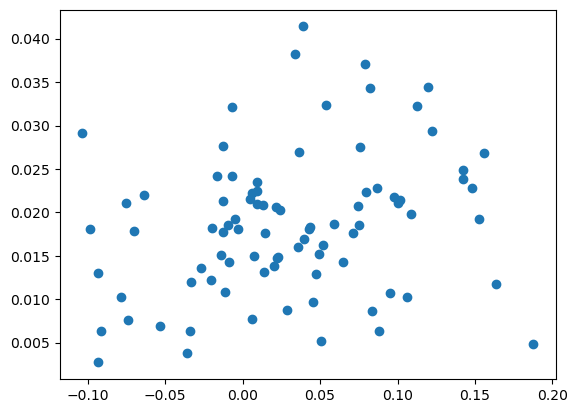

In [62]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep = pm2_growth_per_dep.pct_change(axis=1)
pm2_growth_per_dep = pm2_growth_per_dep.mean(axis=1).to_frame()
add_department_name(pm2_growth_per_dep[0].sort_values(ascending=False).to_frame()).head(10)
pm2_growth_pop_per_dep = add_department_pop(pm2_growth_per_dep)
pm2_growth_pop_per_dep["pop_growth"] = (pm2_growth_pop_per_dep["2025"]-pm2_growth_pop_per_dep["2011"])/pm2_growth_pop_per_dep["2025"]

plt.scatter(
    pm2_growth_pop_per_dep["pop_growth"],
    pm2_growth_pop_per_dep[0]
)

## Per hexagon

In [179]:
# 1. Configuration
# Note : Résolution 3 est très vaste (échelle régionale). 
# Pour des quartiers, visez plutôt 7, 8 ou 9.
resolution = 7

# ---------------------------------------------------------
# OPTIMISATION 1 : Assigning a hexagon to every transaction 
# ---------------------------------------------------------

# On extrait les colonnes en tableaux NumPy purs (.values)
# C'est beaucoup plus rapide que d'accéder à geometry.x ligne par ligne
lats = gdf_final.geometry.y.values
lons = gdf_final.geometry.x.values

# On utilise une compréhension de liste avec zip
# C'est la méthode standard la plus rapide en Python pur
gdf_final['h3_index'] = [
    h3.latlng_to_cell(lat, lon, resolution) 
    for lat, lon in zip(lats, lons)
]


In [39]:
# ---------------------------------------------------------
# OPTIMISATION 2 : Reconstructing the geometry of the h3-hexagon
# ---------------------------------------------------------

def hex_to_poly_optimized(h3_id):
    # cell_to_boundary renvoie ((lat, lon), (lat, lon)...)
    points = h3.cell_to_boundary(h3_id)
    # Inversion (Lat, Lon) -> (Lon, Lat) + Création Polygon
    return Polygon([(lng, lat) for lat, lng in points])

def display_hexagon_map(df_counts,variable):
    # Ici aussi, on évite .apply() pour utiliser une boucle de liste directe
    #we create a geodataframe that assign a geometry to every hexagon
    gdf_h3 = gpd.GeoDataFrame(
        df_counts,
        geometry=[hex_to_poly_optimized(h_id) for h_id in df_counts['h3_index'].values],
        crs="EPSG:4326"
    )

    #displaying the hexagon
    m = gdf_h3.explore(
        column=variable,
        cmap="inferno",
        style_kwds={"fillOpacity": 0.6, "weight": 0},
        tiles="CartoDB positron"
    )
    return m

### Number of transactions per hexagon

In [ ]:
variable = "Number of transactions"
df_counts = gdf_final.groupby('h3_index').size().reset_index(name='Number_transactions')
display_hexagon_map(df_counts, variable)


### Median price of a transation per hexagon

In [ ]:
variable = "Median price of transactions"
df_counts = gdf_final.groupby('h3_index')['valeurfonc'].median().reset_index(name=variable)
display_hexagon_map(df_counts, variable)

### Median p/m2 per hexagon

In [196]:
gdf_final = gdf_final[gdf_final['p/m2'] < np.inf]

In [ ]:


variable = "Median p/m2"
df_counts = gdf_final.groupby('h3_index')['p/m2'].median().reset_index(name=variable)
display_hexagon_map(df_counts, variable)

### Time-series analysis 

#### Nb of constructions

In [27]:
gdf_h3.head()

,h3_index,median,geometry
0,831840fffffffff,2489,"POLYGON ((-3.74217 47.54858, -4.41084 47.15937..."
1,831844fffffffff,265995,"POLYGON ((-3.24366 48.5473, -3.9234 48.16707, ..."
2,831845fffffffff,468011,"POLYGON ((-2.22661 47.68955, -2.89779 47.31226..."
3,831846fffffffff,87233,"POLYGON ((-4.78997 48.39804, -5.46644 48.00564..."
4,831848fffffffff,31,"POLYGON ((-2.2474 44.82036, -2.88979 44.42867,..."


In [200]:
gdf_final.groupby('h3_index').size().reset_index(name='Number_transactions')

,h3_index,Number_transactions
0,871840824ffffff,31
1,871840825ffffff,10
2,871840826ffffff,27
3,871840834ffffff,56
4,871840835ffffff,24
...,...,...
96505,87a2555b2ffffff,183
96506,87a2555b3ffffff,1639
96507,87a2555b4ffffff,73
96508,87a2555b5ffffff,415


#### Median p/m2

<Axes: >

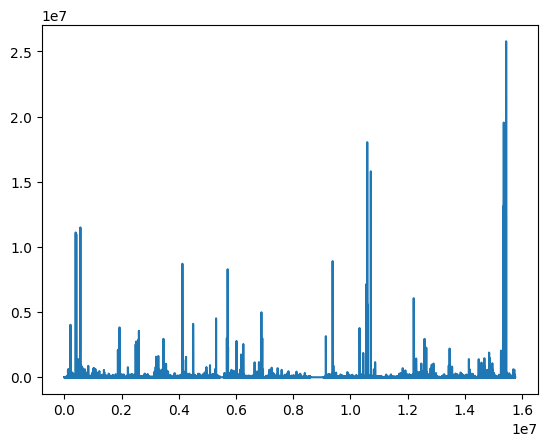

In [ ]:
gdf_final['p/m2'<].plot()


In [ ]:
gdf_final = gdf_final[gdf_final['p/m2'] < np.inf]
gdf_final.head()

,anneemut,datemut,valeurfonc,coddep,sbati,sterr,geompar_x,geompar_y,libtypbien,p/m2,geometry,h3_index
0,2019,2019-11-07,86000.0,79,105.0,157.0,426128.536664,6.630894e+06,UNE MAISON,819.047619,POINT (-0.587 46.72216),87186e28affffff
2,2021,2021-05-19,15000.0,79,50.0,73.0,454294.454579,6.595390e+06,UNE MAISON,300.000000,POINT (-0.1997 46.41366),871868400ffffff
3,2023,2023-05-19,100000.0,79,120.0,2038.0,431277.368041,6.621133e+06,UNE MAISON,833.333333,POINT (-0.51397 46.63644),87186e2deffffff
5,2024,2024-12-06,182000.0,79,82.0,170.0,434700.127784,6.585247e+06,UNE MAISON,2219.512195,POINT (-0.44879 46.31498),87186ab26ffffff
7,2022,2022-12-20,85000.0,79,77.0,0.0,436097.181962,6.586380e+06,UN APPARTEMENT,1103.896104,POINT (-0.43129 46.32572),87186ab26ffffff


In [255]:
pm2_growth_per_hex = gdf_final.groupby(['h3_index','anneemut'])['p/m2'].median().unstack(1)
pm2_growth_per_hex =pm2_growth_per_hex.pct_change()
# log growth : pm2_growth_per_hex = np.log1p(pm2_growth_per_hex).diff(axis=1)

    
pm2_growth_per_hex

/tmp/ipykernel_43187/538764231.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pm2_growth_per_hex =pm2_growth_per_hex.pct_change()


anneemut,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
h3_index,,,,,,,,,,,,
871840824ffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871840825ffffff,-0.014706,0.000000,1.377358,0.000000,0.094687,0.000000,0.170410,-0.841036,0.000000,-0.487190,NaN,0.000000
871840826ffffff,0.291346,0.430306,-0.713140,0.104816,0.135948,-0.244218,0.353884,3.313607,-0.222556,0.288915,NaN,0.426768
871840834ffffff,-0.023629,-0.287037,1.043546,-0.354839,-0.483544,0.119701,0.000000,0.353570,-0.323959,0.030270,-0.067655,0.000000
871840835ffffff,-0.404667,0.000000,-0.202193,0.951049,0.345486,0.420833,-0.175300,0.000000,1.359007,0.109559,0.905828,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
87a2555b2ffffff,-0.162718,-0.115873,-0.175641,-0.149231,-0.251104,-0.232881,-0.244996,-0.236640,-0.209524,-0.099885,-0.135428,-0.165584
87a2555b3ffffff,0.656244,0.402867,0.408107,0.428571,0.451411,0.461185,0.262019,0.217111,0.349398,0.212302,0.118238,0.191473
87a2555b4ffffff,0.290755,0.782065,0.359648,0.440049,0.519121,0.503759,0.499456,0.596452,1.149038,0.457834,0.847858,0.775530


In [256]:
pm2_growth_per_hex = pm2_growth_per_hex.quantile(0.75,axis=1).dropna().sort_values(ascending=False).reset_index()


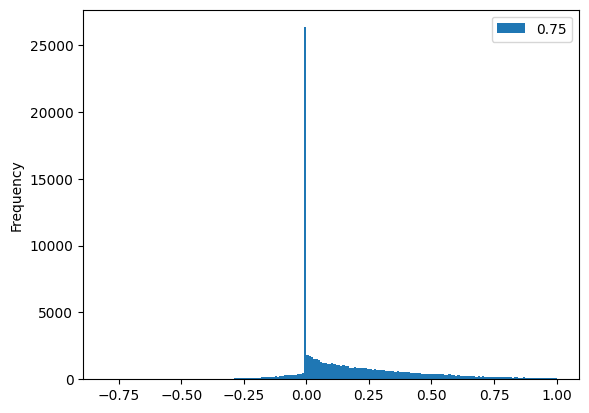

In [258]:
pm2_growth_per_hex.loc[pm2_growth_per_hex[0.75]<1].plot.hist(bins=200)
plt.show()

In [251]:
pm2_growth_per_hex.loc[pm2_growth_per_hex[0]>100].nunique()

h3_index    0
0           0
dtype: int64